In [15]:
import os
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_and_save_images(generator, latent_dim, num_images, save_dir, prefix="img"):
    os.makedirs(save_dir, exist_ok=True)
    generator.eval()
    
    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, latent_dim, 1, 1, device=device)
            fake_image = generator(z).detach().cpu()
            # No need for normalization if the output is already in [0, 1] (sigmoid activation)
            # img = (fake_image + 1) / 2  # Unnormalize from [-1,1] to [0,1]
            img = fake_image
            save_path = os.path.join(save_dir, f"{prefix}_{i+1:04d}.png")
            save_image(img, save_path)
    print(f"Saved {num_images} images to '{save_dir}'")

[Epoch 0/500] [Batch 0/3] [D loss: 0.7186] [G loss: 1.4624]
[Epoch 1/500] [Batch 0/3] [D loss: 1.0950] [G loss: 1.8777]
[Epoch 2/500] [Batch 0/3] [D loss: 0.5642] [G loss: 3.2244]
[Epoch 3/500] [Batch 0/3] [D loss: 0.4845] [G loss: 3.8462]
[Epoch 4/500] [Batch 0/3] [D loss: 0.3887] [G loss: 4.3070]
[Epoch 5/500] [Batch 0/3] [D loss: 0.2718] [G loss: 4.5325]
[Epoch 6/500] [Batch 0/3] [D loss: 0.2533] [G loss: 4.6641]
[Epoch 7/500] [Batch 0/3] [D loss: 0.2960] [G loss: 4.8436]
[Epoch 8/500] [Batch 0/3] [D loss: 0.2896] [G loss: 4.8164]
[Epoch 9/500] [Batch 0/3] [D loss: 0.2194] [G loss: 4.8164]
[Epoch 10/500] [Batch 0/3] [D loss: 0.3197] [G loss: 6.0097]
[Epoch 11/500] [Batch 0/3] [D loss: 0.2403] [G loss: 4.8658]
[Epoch 12/500] [Batch 0/3] [D loss: 0.3193] [G loss: 5.4926]
[Epoch 13/500] [Batch 0/3] [D loss: 0.3197] [G loss: 6.2387]
[Epoch 14/500] [Batch 0/3] [D loss: 0.1354] [G loss: 5.6172]
[Epoch 15/500] [Batch 0/3] [D loss: 0.2324] [G loss: 5.8564]
[Epoch 16/500] [Batch 0/3] [D loss

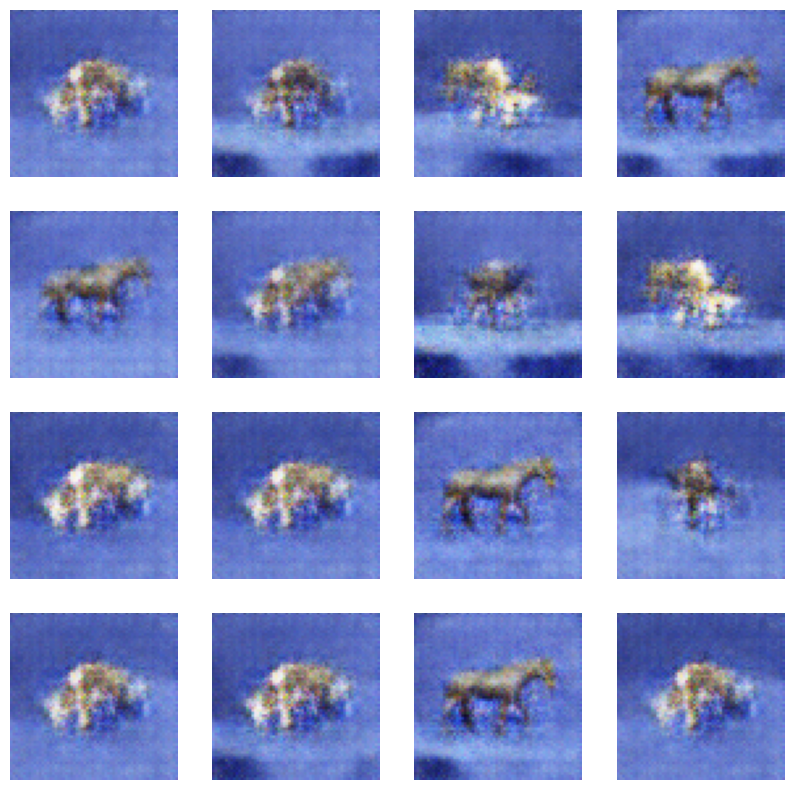

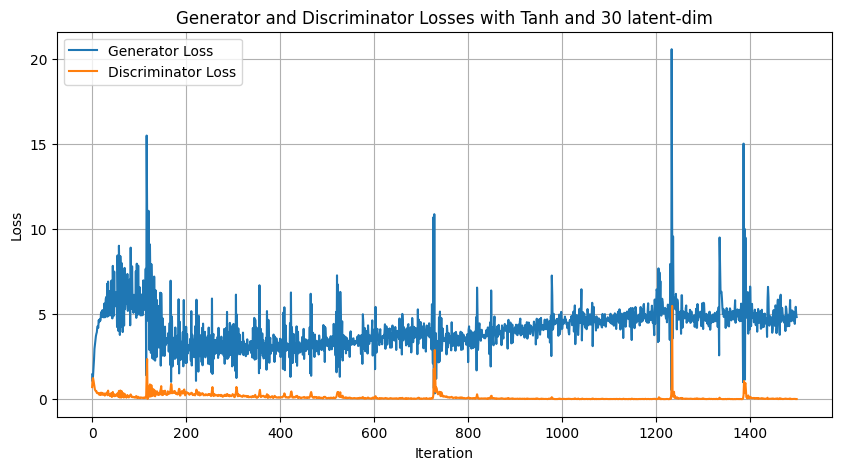

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 30
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with Tanh and 30 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.6951] [G loss: 1.6916]
[Epoch 1/500] [Batch 0/3] [D loss: 1.0978] [G loss: 1.9010]
[Epoch 2/500] [Batch 0/3] [D loss: 0.4998] [G loss: 3.3262]
[Epoch 3/500] [Batch 0/3] [D loss: 0.3962] [G loss: 3.8747]
[Epoch 4/500] [Batch 0/3] [D loss: 0.2206] [G loss: 4.0199]
[Epoch 5/500] [Batch 0/3] [D loss: 0.2168] [G loss: 4.5845]
[Epoch 6/500] [Batch 0/3] [D loss: 0.2019] [G loss: 4.6268]
[Epoch 7/500] [Batch 0/3] [D loss: 0.1589] [G loss: 4.7849]
[Epoch 8/500] [Batch 0/3] [D loss: 0.1842] [G loss: 5.1468]
[Epoch 9/500] [Batch 0/3] [D loss: 0.2529] [G loss: 5.3837]
[Epoch 10/500] [Batch 0/3] [D loss: 0.2421] [G loss: 5.5528]
[Epoch 11/500] [Batch 0/3] [D loss: 0.2366] [G loss: 6.5953]
[Epoch 12/500] [Batch 0/3] [D loss: 0.1695] [G loss: 5.5267]
[Epoch 13/500] [Batch 0/3] [D loss: 0.3605] [G loss: 7.4450]
[Epoch 14/500] [Batch 0/3] [D loss: 0.1705] [G loss: 5.5626]
[Epoch 15/500] [Batch 0/3] [D loss: 0.2502] [G loss: 6.5397]
[Epoch 16/500] [Batch 0/3] [D loss

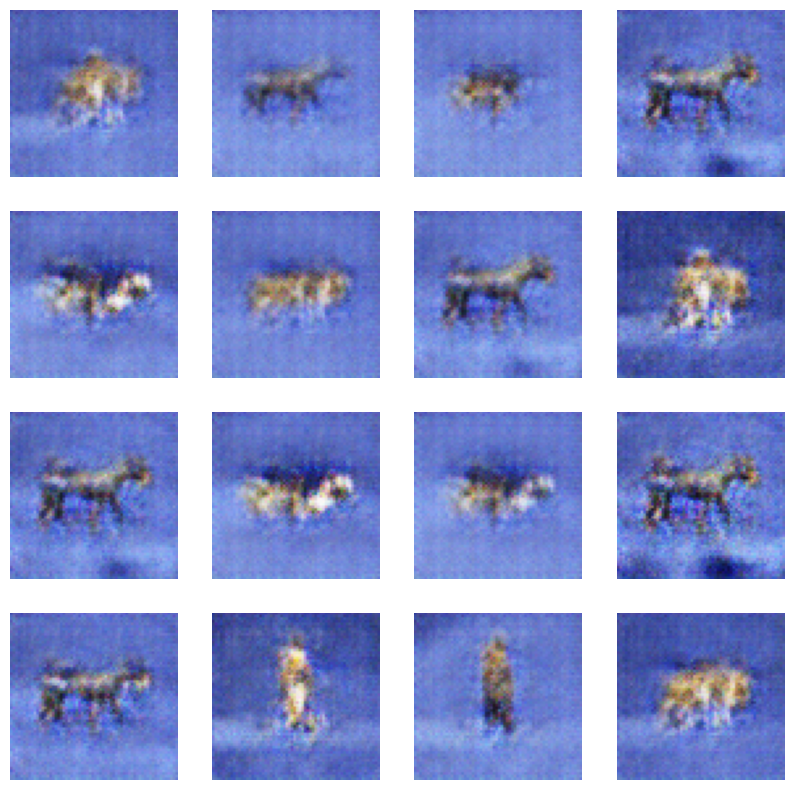

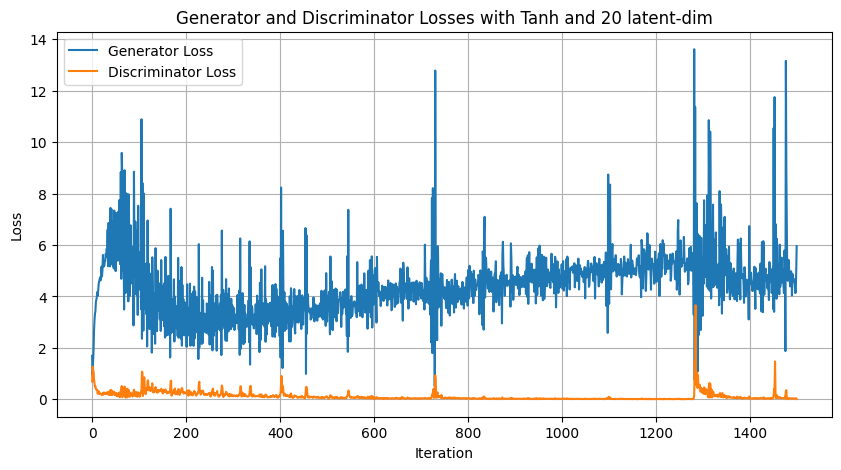

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with Tanh and 20 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.7771] [G loss: 1.5482]
[Epoch 1/500] [Batch 0/3] [D loss: 0.4231] [G loss: 2.8054]
[Epoch 2/500] [Batch 0/3] [D loss: 0.2919] [G loss: 3.3184]
[Epoch 3/500] [Batch 0/3] [D loss: 0.1926] [G loss: 3.8318]
[Epoch 4/500] [Batch 0/3] [D loss: 0.1249] [G loss: 4.3450]
[Epoch 5/500] [Batch 0/3] [D loss: 0.1195] [G loss: 4.2212]
[Epoch 6/500] [Batch 0/3] [D loss: 0.1790] [G loss: 5.1284]
[Epoch 7/500] [Batch 0/3] [D loss: 0.1295] [G loss: 4.0921]
[Epoch 8/500] [Batch 0/3] [D loss: 0.1194] [G loss: 3.6670]
[Epoch 9/500] [Batch 0/3] [D loss: 0.2258] [G loss: 6.6417]
[Epoch 10/500] [Batch 0/3] [D loss: 0.2012] [G loss: 6.9826]
[Epoch 11/500] [Batch 0/3] [D loss: 0.0421] [G loss: 5.9760]
[Epoch 12/500] [Batch 0/3] [D loss: 0.0983] [G loss: 4.4519]
[Epoch 13/500] [Batch 0/3] [D loss: 0.0932] [G loss: 5.8414]
[Epoch 14/500] [Batch 0/3] [D loss: 1.4715] [G loss: 3.5995]
[Epoch 15/500] [Batch 0/3] [D loss: 0.1027] [G loss: 5.9560]
[Epoch 16/500] [Batch 0/3] [D loss

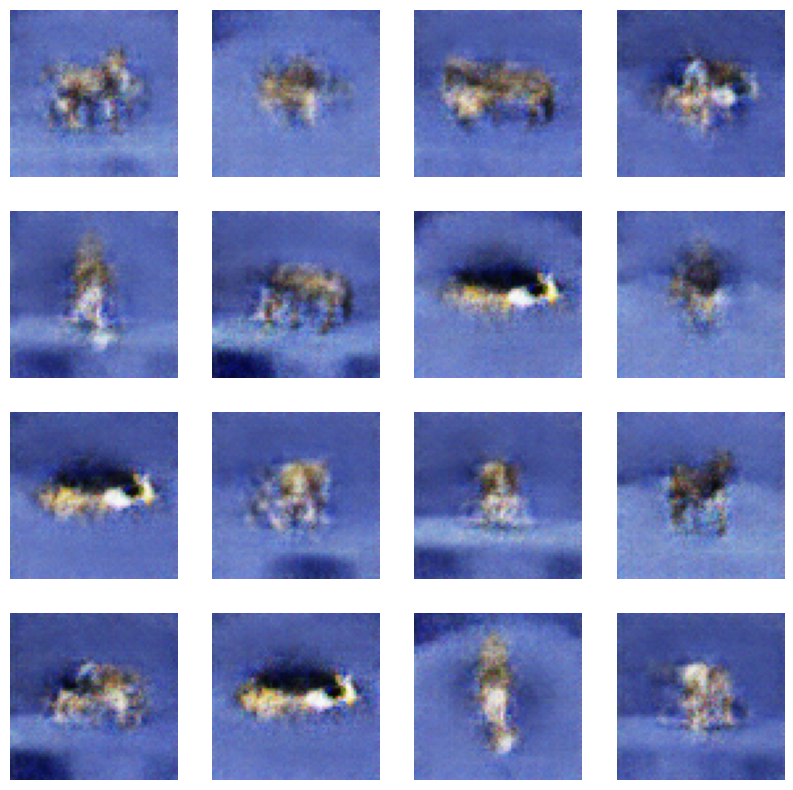

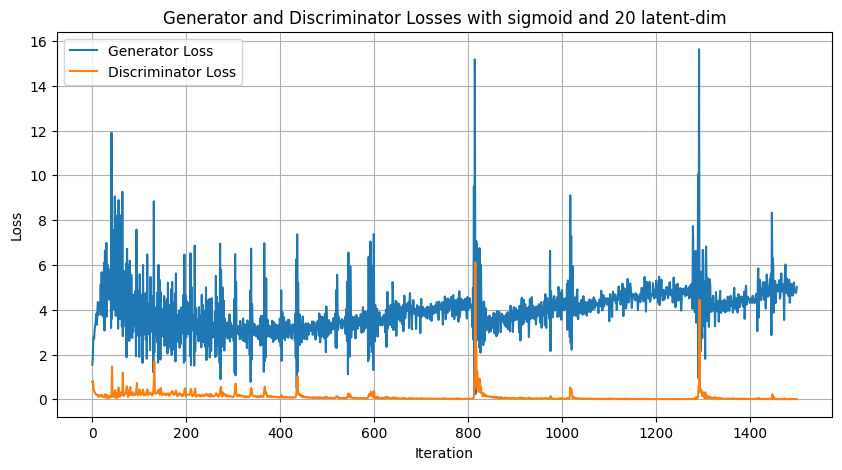

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor()
    # Removed normalization
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Using Sigmoid instead of Tanh
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 20
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = img  # Removed unnormalization
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with sigmoid and 20 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

[Epoch 0/500] [Batch 0/3] [D loss: 0.7079] [G loss: 1.6576]
[Epoch 1/500] [Batch 0/3] [D loss: 0.4059] [G loss: 2.9004]
[Epoch 2/500] [Batch 0/3] [D loss: 0.2316] [G loss: 3.6320]
[Epoch 3/500] [Batch 0/3] [D loss: 0.1364] [G loss: 4.0215]
[Epoch 4/500] [Batch 0/3] [D loss: 0.1126] [G loss: 4.4362]
[Epoch 5/500] [Batch 0/3] [D loss: 0.0990] [G loss: 4.6353]
[Epoch 6/500] [Batch 0/3] [D loss: 0.1614] [G loss: 5.8549]
[Epoch 7/500] [Batch 0/3] [D loss: 0.0620] [G loss: 5.7486]
[Epoch 8/500] [Batch 0/3] [D loss: 0.1097] [G loss: 5.8999]
[Epoch 9/500] [Batch 0/3] [D loss: 0.0874] [G loss: 5.5168]
[Epoch 10/500] [Batch 0/3] [D loss: 0.0882] [G loss: 4.3510]
[Epoch 11/500] [Batch 0/3] [D loss: 0.0490] [G loss: 4.6163]
[Epoch 12/500] [Batch 0/3] [D loss: 0.0264] [G loss: 4.9849]
[Epoch 13/500] [Batch 0/3] [D loss: 0.0467] [G loss: 4.4781]
[Epoch 14/500] [Batch 0/3] [D loss: 0.0951] [G loss: 6.3478]
[Epoch 15/500] [Batch 0/3] [D loss: 0.0595] [G loss: 5.3326]
[Epoch 16/500] [Batch 0/3] [D loss

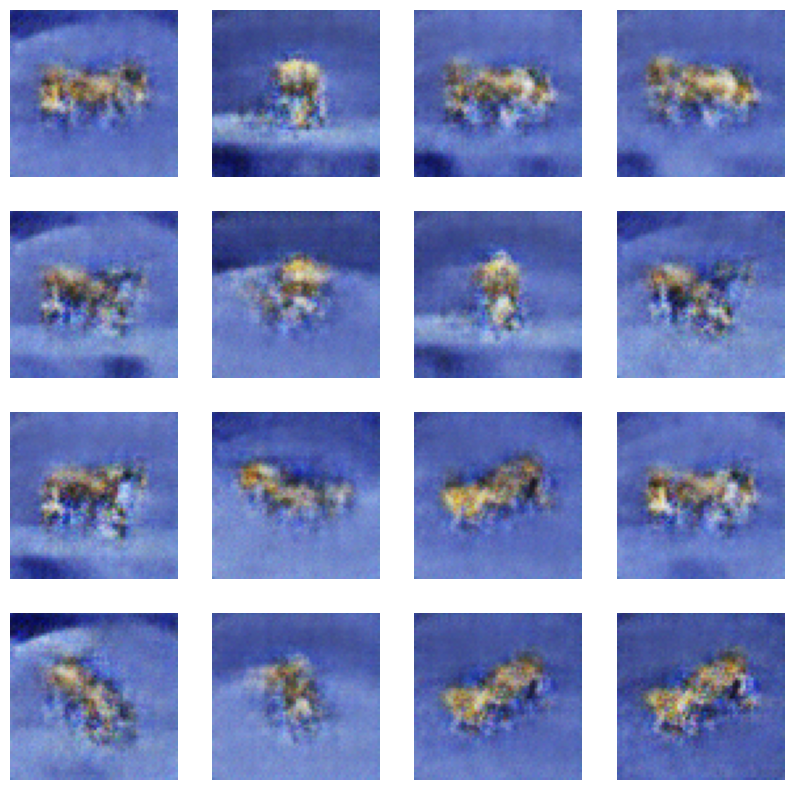

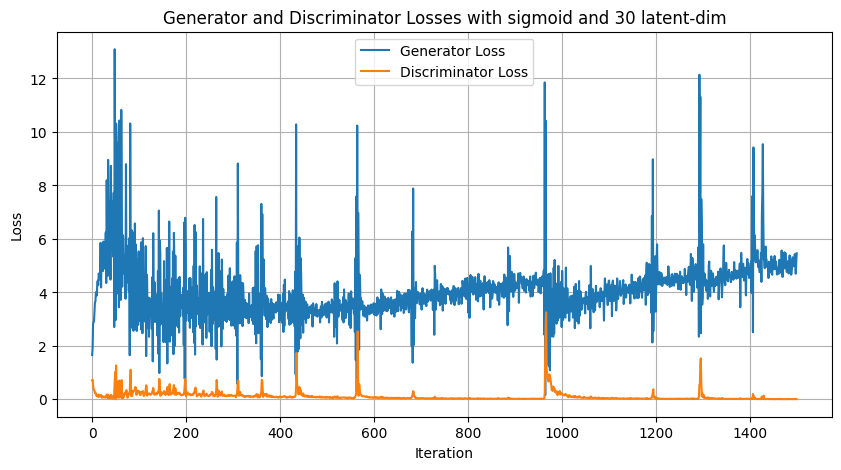

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 for GAN
    transforms.ToTensor()
    # Removed normalization
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# ----------------------------
# Generator Network
# ----------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. 64*8 x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. 64*4 x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. 64*2 x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Sigmoid()  # Using Sigmoid instead of Tanh
            # state size. channels x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# ----------------------------
# Discriminator Network
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is channels x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*2 x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*4 x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64*8 x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# ----------------------------
# Training Setup
# ----------------------------
latent_dim = 30
channels = 3  # RGB images

generator = Generator(latent_dim, channels).to(device)
discriminator = Discriminator(channels).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 500
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)  # For generating samples

# Lists to store losses
G_losses = []
D_losses = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, device=device)
        fake = torch.zeros(batch_size, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)

        # Generate a batch of images
        fake_images = generator(z).detach()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = criterion(discriminator(real_images), valid)
        fake_loss = criterion(discriminator(fake_images), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_images = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = criterion(discriminator(fake_images), valid)

        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training complete.")

# ----------------------------
# Print Generated Images
# ----------------------------
with torch.no_grad():
    fake_images = generator(fixed_noise).detach().cpu()

# Plot a few generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].numpy().transpose(1, 2, 0)
    img = img  # Removed unnormalization
    ax.imshow(img)
    ax.axis('off')
plt.show()

# ----------------------------
# Plot Losses
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses with sigmoid and 30 latent-dim')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
generate_and_save_images(generator, latent_dim, num_images=50, save_dir=f"fake_data/sigmoid-{latent_dim}-latent-dim/Cow", prefix="cow")
generate_and_save_images(generator, latent_dim, num_images=50, save_dir=f"fake_data/sigmoid-{latent_dim}-latent-dim/Horse", prefix="horse")

Saved 50 images to 'fake_data/sigmoid-30-latent-dim/Cow'
Saved 50 images to 'fake_data/sigmoid-30-latent-dim/Horse'
